In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch
import seaborn as sns


from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
def get_test_train(output, csv_path, patch_size):
    # Extract patches from the output feature maps
    output_patches = output.unfold(1, patch_size, 1).unfold(2, patch_size, 1)
    print(output_patches.size())

    # Flatten the patches
    output_patches_flattened = output_patches.reshape(output_patches.shape[0], -1)
    print(output_patches_flattened.shape)

    # Load the CSV file
    df = pd.read_csv(csv_path)
    df.fillna(0, inplace=True)

    # Create a dictionary where the keys are the (X, Y) coordinates and the values are the class labels
    csv_dict = {(row['X'], row['Y']): row for _, row in df.iterrows()}

    # Initialize the features and labels
    features = []
    labels = []


    # For each patch
    for y in range(0, output.shape[0] - patch_size + 1):
        for x in range(0, output.shape[1] - patch_size + 1):
            # Get the class labels for the corresponding region in the CSV file
            patch_labels = [csv_dict.get((x + dx, y + dy))['Class'] for dx in range(patch_size) for dy in range(patch_size) if csv_dict.get((x + dx, y + dy)) is not None]

            # If there are any class labels for the corresponding region in the CSV file
            if patch_labels:
                # Get the most common class label in the region
                most_common_label = stats.mode(patch_labels)[0][0]

                features.append(np.concatenate([output_patches_flattened[y * output.shape[1] + x, :], df.loc[
                                                    (df['X'] == x) & (df['Y'] == y), df.columns[3:]].mean().values]))

                # Add the most common class label to the labels
                labels.append(most_common_label)


    # Handle NaN values
    features = np.nan_to_num(features, nan=0.0)

    # Encode the class labels as integers
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    # Split the features and labels into a training set and a test set
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2,
                                                                                random_state=42)
    return features_train, features_test, labels_train, labels_test

In [4]:
# def logisticRegression(features_train, features_test, labels_train, labels_test):
#     # Train the logistic regression model

#     scaler = StandardScaler()
#     features_train = scaler.fit_transform(features_train)
#     features_test = scaler.transform(features_test)

#     print("Training")
#     clf = LogisticRegression(max_iter=1000, solver= 'newton-cg')
#     clf.fit(features_train, labels_train)


#     print("Predicting")
#     predicted_labels = clf.predict(features_test)

#     accuracy = accuracy_score(labels_test, predicted_labels)
#     print("Accuracy: " + str(accuracy))
#     c_matrix = confusion_matrix(labels_test, predicted_labels)
#     print("Confusion Matrix: " + str(c_matrix))

#     c_matrix = confusion_matrix(labels_test, predicted_labels)
#     sns.heatmap(c_matrix, annot=True, fmt='d')
#     plt.show()

In [ ]:
def logisticRegression(features_train, features_test, labels_train, labels_test):
    # Existing code...

    # Define the parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)

    # Fit the GridSearchCV object to the data
    grid_search.fit(features_train, labels_train)

    # Print the best parameters
    print("Best Parameters: ", grid_search.best_params_)

    # Use the best model to make predictions
    clf = grid_search.best_estimator_
    predicted_labels = clf.predict(features_test)

    accuracy = accuracy_score(labels_test, predicted_labels)
    print("Accuracy: " + str(accuracy))
    c_matrix = confusion_matrix(labels_test, predicted_labels)
    print("Confusion Matrix: " + str(c_matrix))

    c_matrix = confusion_matrix(labels_test, predicted_labels)
    sns.heatmap(c_matrix, annot=True, fmt='d')
    plt.show()

In [19]:
def runRF(features_train, features_test, labels_train, labels_test):
	rf_model = RandomForestClassifier()
	rf_model.fit(features_train, labels_train)
	y_train_preds = rf_model.predict(features_train)
	y_train_prob = rf_model.predict_proba(features_train)
	y_test_preds = rf_model.predict(features_test)
	y_test_prob = rf_model.predict_proba(features_test)
	
	accuracy = accuracy_score(labels_test, y_test_preds)
	print("Accuracy: " + str(accuracy))

	# Print the confusion matrix
	c_matrix = confusion_matrix(labels_test, y_test_preds)
	print("Confusion Matrix: ")
	print(c_matrix)

		# Print the classification report
	print("Classification Report: ")
	print(classification_report(labels_test, y_test_preds))

	# Visualize the confusion matrix using a heatmap
	plt.figure(figsize=(10,7))
	sns.heatmap(c_matrix, annot=True, fmt='d')
	plt.xlabel('Predicted')
	plt.ylabel('Truth')
	plt.show()

In [21]:
csv_path = r"C:\Users\tsang\Documents\GitHub\DESI-project\2021 03 29 colon 0462641-2 Analyte 2_dataset balanced.csv"
patch_size = 5

output = np.load(r"C:\Users\tsang\OneDrive - Queen's University\DESI project\DESI TXT colon\dc-DeepMSI outputs\2021 03 29 colon 0462641\0462641-5 output.npy")

output = torch.from_numpy(output)
#torch.Size([51980, 30]) torch.Size([51980, 30])

features_train, features_test, labels_train, labels_test = get_test_train(output, csv_path, patch_size)

torch.Size([50500, 96, 1, 5])
torch.Size([50500, 480])


In [26]:
logisticRegression(features_train, features_test, labels_train, labels_test)

c:\Users\tsang\anaconda3\envs\DESIproject\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\tsang\anaconda3\envs\DESIproject\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\tsang\anaconda3\envs\DESIproject\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy: 0.8675282714054927
Confusion Matrix: 
[[ 75   3   1   3   3]
 [ 18  82   0   5   2]
 [  0   0  88   9   6]
 [  1   4   2 174   7]
 [  2   0   1  15 118]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        85
           1       0.92      0.77      0.84       107
           2       0.96      0.85      0.90       103
           3       0.84      0.93      0.88       188
           4       0.87      0.87      0.87       136

    accuracy                           0.87       619
   macro avg       0.87      0.86      0.86       619
weighted avg       0.87      0.87      0.87       619



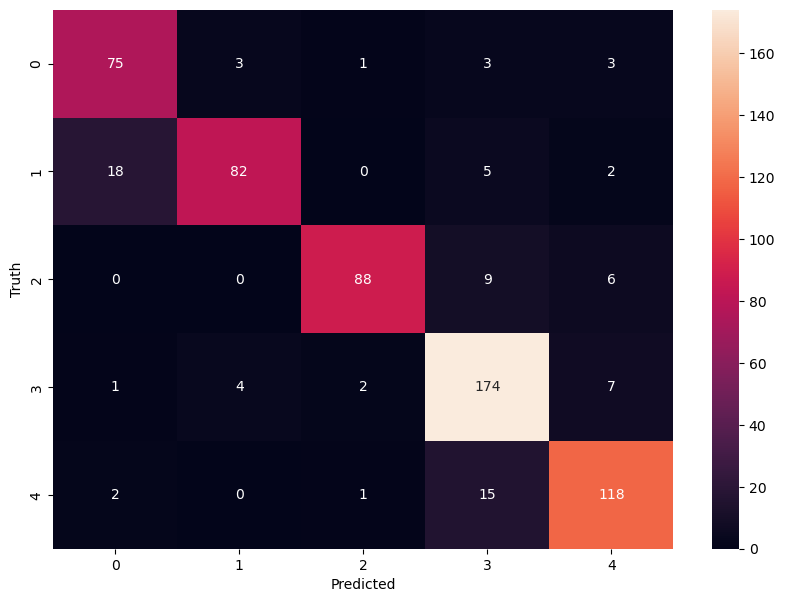

In [23]:
runRF(features_train, features_test, labels_train, labels_test)